<h1>Capstone Project Final Report</h1>
<h2>ECG Classification with Convolutional Neural Networks</h2>

|                 Class name                 | Abbreviation |
|:------------------------------------------:|:------------:|
|                   Normal                   |       N      |            
|  R-on-T premature ventricular contraction  |       r      |             
| Supraventricular premature or ectopic beat |       S      |           
|      Premature ventricular contraction     |       V      |            
|             Unclassifiable beat            |       Q      |      

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

ECGdataset_trn = pd.read_pickle('ECG5000_train.pickle')
ECGdataset_vld = pd.read_pickle('ECG5000_validation.pickle')
display(ECGdataset_trn.shape, ECGdataset_vld.shape)

class_labels, class_counts = np.unique(ECGdataset_trn[:, 0], return_counts=True)
label_counts = dict(zip(class_labels, class_counts))
rename_map = {0.0: 'N', 1.0: 'r', 2.0: 'S', 3.0: 'V', 4.0: 'Q'}
renamed_class_labels = {rename_map.get(key, key): value for key, value in label_counts.items()}

print(f'class counts {label_counts}')
print(f'corresponding class names: {renamed_class_labels}\nnumber of classes {len(class_labels)}')

ECGdataset = np.vstack((ECGdataset_trn, ECGdataset_vld))

X_trn, y_trn = feature_label_split(ECGdataset_trn)
X_vld, y_vld = feature_label_split(ECGdataset_vld)



(500, 141)

(1500, 141)

class counts {0.0: 292, 1.0: 177, 2.0: 10, 3.0: 19, 4.0: 2}
corresponding class names: {'N': 292, 'r': 177, 'S': 10, 'V': 19, 'Q': 2}
number of classes 5


<h2>Data Visualization</h2>

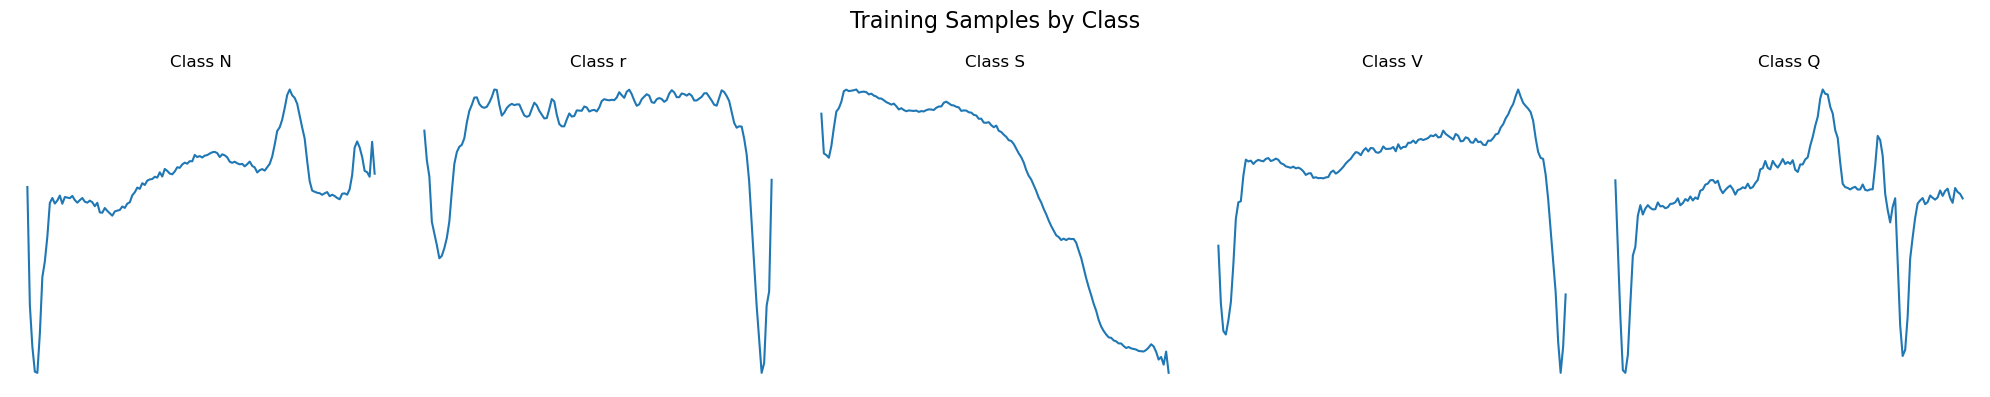

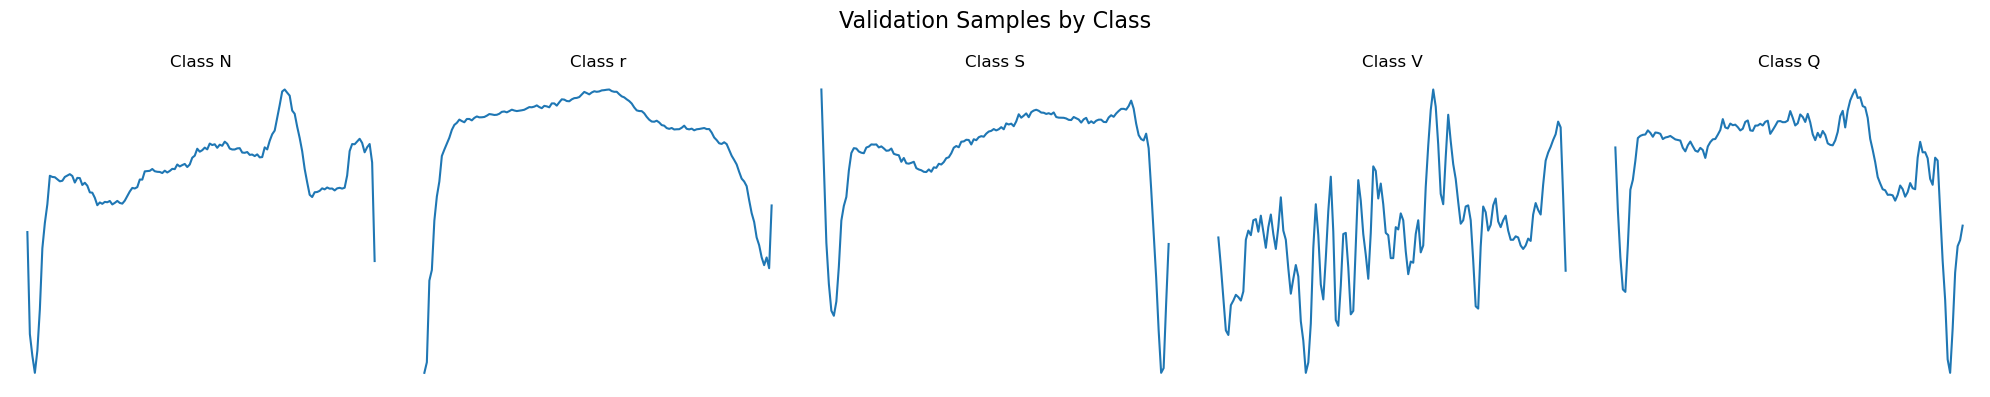

In [150]:
from util.data import get_class_locs
from util.data import get_target_names_class_labels
from util.data import plot_ecg

#plot first sample of each class
trn_sample_locs = get_class_locs(y_trn)
vld_sample_locs = get_class_locs(y_vld)
class_labels, target_names = get_target_names_class_labels(rename_map)

plot_ecg(trn_sample_locs, vld_sample_locs, target_names, X_trn)
plot_ecg(trn_sample_locs, vld_sample_locs, target_names, X_vld, True)


<h2>Data Preprocessing</h2>

In [152]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from scipy.signal import cwt, ricker

class CWTTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, widths=np.arange(1, 24)):
        self.widths = widths
    
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        #apply the CWT to each row
        X_cwt = np.array([cwt(row, ricker, self.widths) for row in X])
        
        return X_cwt
    
class ReshapeData(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        #transform data from 2d to 3d
        X_3d = np.expand_dims(X, axis=-1)
        X_3d = np.repeat(X_3d, 3, axis=-1)
        
        return X_3d

class ImageNormalization(BaseEstimator, TransformerMixin): 
    def fit(self, X,  y= None):
        return self
    
    def transform(self, X, y= None):
        return (X/255).astype(np.float16)

def reshape_y(y_trn, y_vld=None):
    if y_vld is not None:
        y_trn_clean = to_categorical(y_trn, num_classes=5)
        y_vld_clean = to_categorical(y_vld, num_classes=5)
        return y_trn_clean, y_vld_clean

    y_trn_clean = to_categorical(y_trn, num_classes=5)
    
    return y_trn_clean
    
def data_prep(training_data, validation_data):
    #get features and labels
    X_trn, y_trn, X_vld, y_vld = feature_label_split(training_data, validation_data)

    #preprocess features
    cwt_pipeline = Pipeline([
        ('apply cwt', CWTTransformer()),
        ('image norm', ImageNormalization()),
    ])

    X_trn_cwt = cwt_pipeline.fit_transform(X_trn)
    X_vld_cwt = cwt_pipeline.fit_transform(X_vld)

    trn_sample_locs = get_class_locs(y_trn)
    vld_sample_locs = get_class_locs(y_vld)
    display_cwt_image(trn_sample_locs, vld_sample_locs, X_trn_cwt)
    display_cwt_image(trn_sample_locs, vld_sample_locs, X_vld_cwt, True)
    
    feature_pipeline = Pipeline([
        ('reshape data', ReshapeData())
    ])

    X_trn_clean = feature_pipeline.fit_transform(X_trn_cwt)
    X_vld_clean = feature_pipeline.transform(X_vld_cwt)

    #preprocess labels
    y_trn_clean, y_vld_clean = reshape_y(y_trn, y_vld)
    
    return X_trn_clean, y_trn_clean, X_vld_clean, y_vld_clean

def run_metrics(history):
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

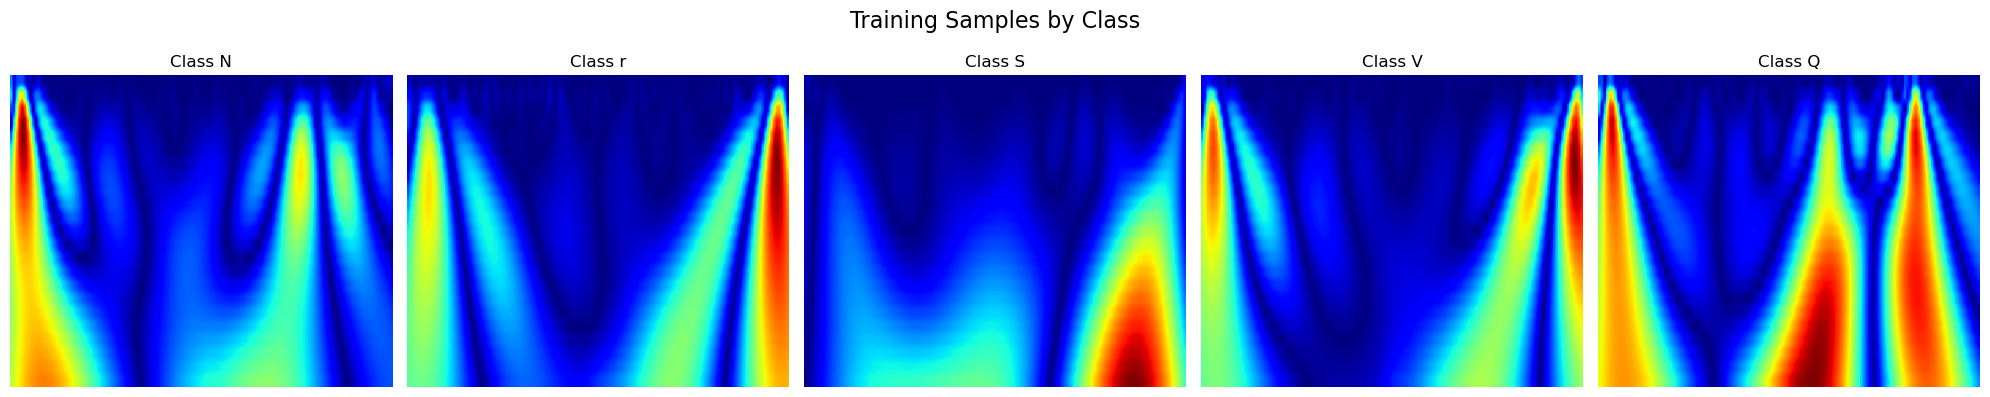

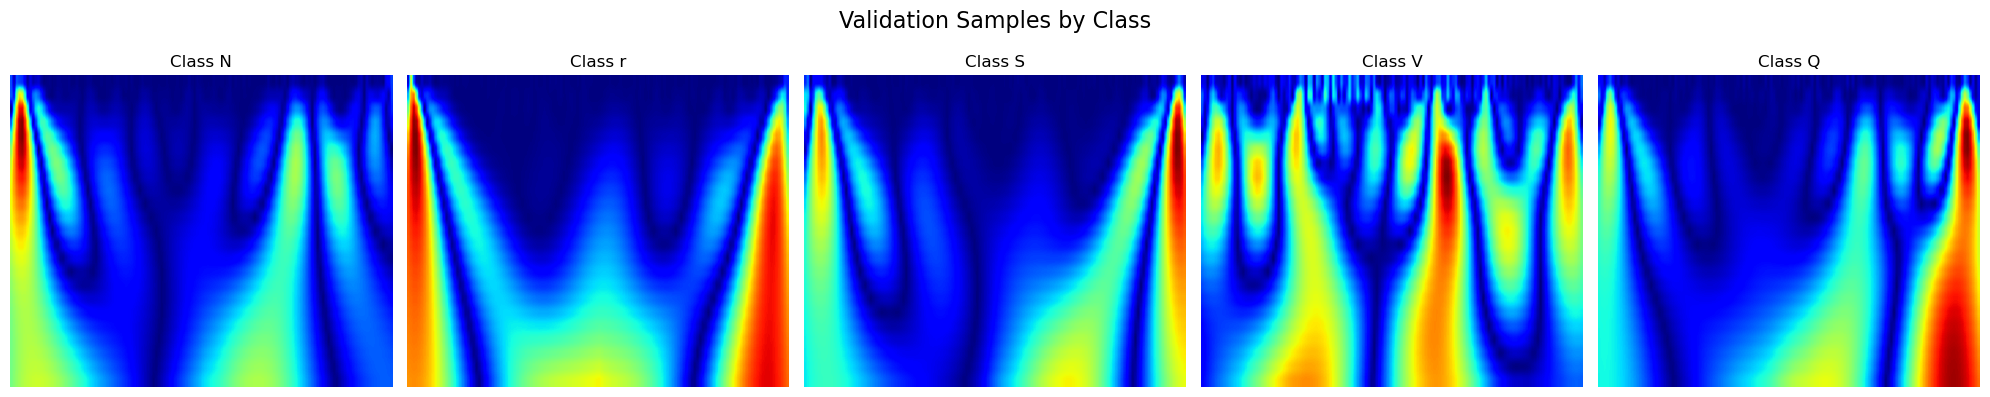

X_trn shape (500, 140)
y_trn shape (500,)
X_trn shape after cwt transform (500, 23, 140, 3)
X_vld shape after cwt transform (1500, 23, 140, 3)
y_trn shape after dataprep (500, 5)
y_vld shape after dataprep (1500, 5)


In [153]:
X_trn_clean, y_trn_clean, X_vld_clean, y_vld_clean = data_prep(ECGdataset_trn, ECGdataset_vld)


print(f'X_trn shape {X_trn.shape}')
print(f'y_trn shape {y_trn.shape}')
print(f'X_trn shape after cwt transform {X_trn_clean.shape}')
print(f'X_vld shape after cwt transform {X_vld_clean.shape}')
print(f'y_trn shape after dataprep {y_trn_clean.shape}')
print(f'y_vld shape after dataprep {y_vld_clean.shape}')



<h2>Training the model</h2>

In [140]:
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight

#balance weights for all classes
class_labels = list(rename_map.keys())
class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=y_trn)
class_weights_dict = dict(zip(class_labels, class_weights))

#define the model
model = models.Sequential([
    layers.Input(shape=X_trn_clean.shape[1:]),  #height, width, channels
    
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.Dropout(0.2),
    
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.Dropout(0.2),
    
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dropout(0.1),
    
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.6),
    
    layers.Dense(5, activation='softmax')  #softmax for multiclass
])

#compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#train the model
history = model.fit(X_trn_clean, 
                    y_trn_clean, 
                    epochs=20, 
                    batch_size=50,
                    validation_data=(X_vld_clean, y_vld_clean),
                    class_weight=class_weights_dict)

Epoch 1/20
10/10 [==============================] - 8s 718ms/step - loss: 1.6168 - accuracy: 0.3980 - val_loss: 1.5311 - val_accuracy: 0.8860
Epoch 2/20
10/10 [==============================] - 7s 747ms/step - loss: 1.5030 - accuracy: 0.7320 - val_loss: 1.0124 - val_accuracy: 0.8747
Epoch 3/20
10/10 [==============================] - 7s 738ms/step - loss: 1.5186 - accuracy: 0.7720 - val_loss: 1.1760 - val_accuracy: 0.8040
Epoch 4/20
10/10 [==============================] - 7s 747ms/step - loss: 1.3693 - accuracy: 0.7640 - val_loss: 1.2386 - val_accuracy: 0.7873
Epoch 5/20
10/10 [==============================] - 7s 712ms/step - loss: 1.1421 - accuracy: 0.8160 - val_loss: 0.5945 - val_accuracy: 0.8887
Epoch 6/20
10/10 [==============================] - 7s 733ms/step - loss: 0.8256 - accuracy: 0.8600 - val_loss: 0.4697 - val_accuracy: 0.8740
Epoch 7/20
10/10 [==============================] - 7s 709ms/step - loss: 1.0828 - accuracy: 0.8100 - val_loss: 0.6196 - val_accuracy: 0.8607
Epoch 

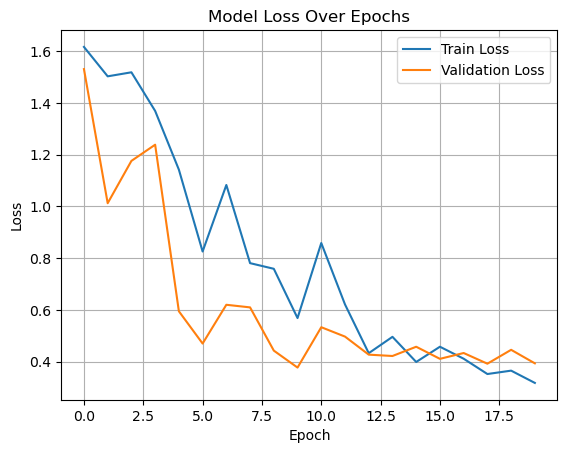

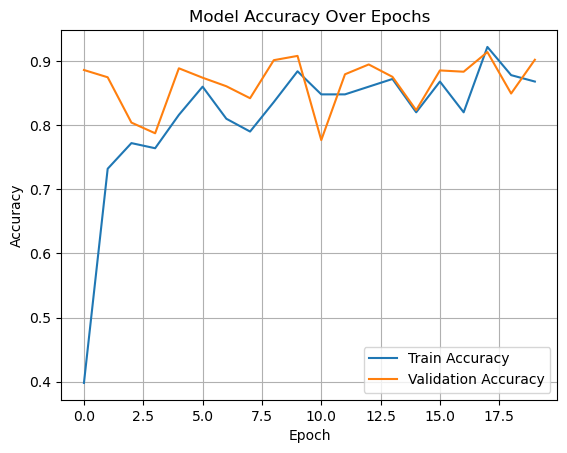

47/47 [==============================] - 3s 53ms/step


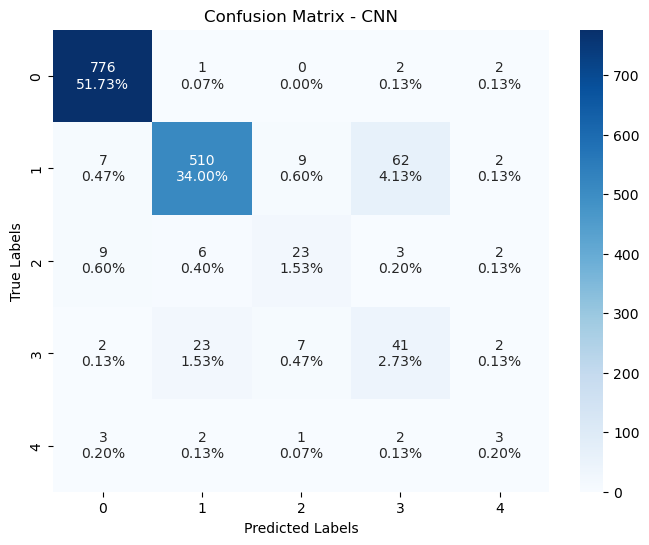


-----------Convolutional Neural Network Classification Report----------------
              precision    recall  f1-score   support

           N       0.97      0.99      0.98       781
           r       0.94      0.86      0.90       590
           S       0.57      0.53      0.55        43
           V       0.37      0.55      0.44        75
           Q       0.27      0.27      0.27        11

    accuracy                           0.90      1500
   macro avg       0.63      0.64      0.63      1500
weighted avg       0.91      0.90      0.91      1500



In [149]:
run_metrics(history)

#get predictions
y_probs = model.predict(X_vld_clean)
preds = np.argmax(y_probs, axis=1)  

#if y_vld_clean is one-hot encoded, convert it
if y_vld_clean.ndim > 1:
    y_vld = np.argmax(y_vld_clean, axis=1)
else:
    y_vld = y_vld_clean

#confusion matrix
cf_matrix = confusion_matrix(y_vld, preds)

plt.figure(figsize=(8, 6))

group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}" for v1, v2, in zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(5,5)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - CNN')
plt.show()

#classification report
target_names = list(rename_map.values())
print('\n-----------Convolutional Neural Network Classification Report----------------')
print(classification_report(y_vld, preds, labels=class_labels, target_names=target_names))
